In [23]:
import numpy as np
import math
from itertools import combinations
import pandas as pd
# KLD of selected_client_distribution: 0.009202024952274953
# Mean KLD of client_distribution: 0.07628563850355953

In [24]:
class Client:
    def __init__(self, attributes):
        self.attributes = attributes
        self.clientID = int(attributes[0] - 1)

        self.distribution = np.array( attributes[1:-1])
        self.union_dist=np.full(len(self.distribution), 1 / len(self.distribution))
        self.kl_divergence = self.calculate_kl_divergence()
        self.completion_time = attributes[-1]

    def __hash__(self):
        return hash(self.clientID)

    def __eq__(self, other):
        if not isinstance(other, Client):
            return NotImplemented
        return self.clientID == other.clientID

    def get_distribution(self):
        return self.distribution

    def get_attributes(self):
        return self.attributes

    def get_clientID(self):
        return self.clientID

    def get_kl_divergence(self):
        return self.kl_divergence
    
    def get_completion_time(self):
        return self.completion_time
    
    def calculate_kl_divergence(self):
        """
        计算两个分布之间的KL散度。
        :param p: 分布P，一个概率分布数组。
        :param q: 分布Q，另一个概率分布数组。
        :return: P和Q之间的KL散度。
        """
        # 确保概率分布不包含0，因为log(0)是未定义的
        client_dist = self.distribution / sum(self.distribution)
        client_dist = np.maximum(client_dist, 1e-12)
        union_dist = np.maximum(self.union_dist, 1e-12)
        
        return np.sum(client_dist * np.log(client_dist / union_dist)) 
    
    def __str__(self) -> str:
        return f"Client ID:{self.clientID}. Distribution:{self.distribution}. KL Divergence:{self.kl_divergence}"
        # print("Client distribution:", self.distribution)

# Example usage
attributes = [1, 5, 4, 3, 7, 2, 8, 6]  # Example list of attributes
client = Client(attributes)
print("Client ID:", client.get_clientID())
print("Client distribution:", client.get_distribution())
print("Client kl divergence:", client.calculate_kl_divergence())


Client ID: 0
Client distribution: [5 4 3 7 2 8]
Client kl divergence: 0.09796024650365569


In [25]:
import math
class Group:
    def __init__(self, clients):
        # if len(clients) != get_clients_per_group():
        #     raise ValueError(f"A complete group must have: {get_clients_per_group()} clients!")

        self.clients = clients


        self.union_dist=np.full(len(self.clients[0].get_distribution()), 1 / len(self.clients[0].get_distribution()))
        self.update_group_info()

    def __contains__(self, client):
        return client.get_clientID() in self.clients_ids

    def update_group_info(self):
        self.clients_ids = [client.get_clientID() for client in self.clients]
        self.clients_num = len(self.clients)
        self.total_distribution = np.sum([client.get_distribution() for client in self.clients], axis=0)
        self.group_distribution = self.calculate_group_distribution()
        self.group_client_completion_time = [client.get_completion_time() for client in self.clients]
        self.group_kl_divergence = self.calculate_group_kl_divergence()
        self.group_variance = self.calculate_group_variance()
        self.group_mean_kl_divergence = np.mean([client.kl_divergence for client in self.clients])
        self.group_measure_value = self.get_group_measure()

    def remove_client(self, client):
        self.clients.remove(client)
        if len(self.clients) == 0:
            return None
        self.update_group_info()

    def add_client(self, client):
        self.clients.append(client)
        self.update_group_info()

    def judge_add_a_client(self, client):
        # 评估加入client后的KL散度
        temp_group = Group(self.clients + [client])
        return temp_group.get_group_measure() - self.get_group_measure()
    
    def split_group(self):
        groups_by_completion_time = {}
        for client in self.clients:
            if client.get_completion_time() not in groups_by_completion_time.keys():
                groups_by_completion_time[client.get_completion_time()] = []
            groups_by_completion_time[client.get_completion_time()].append(client)
        return groups_by_completion_time

    def calculate_group_kl_divergence(self):
        """
        计算两个分布之间的KL散度。
        :param p: 分布P，一个概率分布数组。
        :param q: 分布Q，另一个概率分布数组。
        :return: P和Q之间的KL散度。
        """
        # 确保概率分布不包含0，因为log(0)是未定义的
        group_dist = np.maximum(self.group_distribution, 1e-12)
        union_dist = np.maximum(self.union_dist, 1e-12)
        
        return np.sum(group_dist * np.log(group_dist / union_dist))   

    def calculate_group_distribution(self):
        """
        计算组内所有客户的分布的平均值。
        :return: 组内所有客户的分布的平均值。
        """
        distribution_sum = self.total_distribution

        return distribution_sum / sum(distribution_sum)
    
    def calculate_group_variance(self):
        """
        计算组内所有客户的时间开销上的方差。
        :return: 组内所有客户的分布的方差。
        """
        return np.var(self.group_client_completion_time)
    
    def get_group_measure(self, alpha=0.9,beta= 0.1):
        # kl_fitness = 1 / (1e-2 + self.group_kl_divergence ** 2 )
        # variance_fitness = 1 / (1e-2 + self.calculate_group_variance() ** 2 / self.clients_num)
        # return kl_fitness *  variance_fitness

        return 1 / math.sqrt( 1e-3 + alpha * self.group_kl_divergence ** 2 + beta * self.get_min_max_completion_time() ** 2 / self.clients_num)
    
    def get_min_max_completion_time(self):
        return max(self.group_client_completion_time)- min(self.group_client_completion_time)

    def __str__(self) -> str:
        return f"Group of {self.clients_num} clients. Group Distribution:{self.group_distribution}. Group KL Divergence:{self.group_kl_divergence}, Group Variance:{self.calculate_group_variance()}, Group Measure Value:{self.group_measure_value}"
    
    def print_result(self):
        print("Group of", self.clients_num, "clients.")
        print("Group Distribution:", self.group_distribution)
        print("Group Completion Time:", self.group_client_completion_time)
        print("Group KL Divergence:", self.group_kl_divergence)
        print("Group Variance:", self.calculate_group_variance())
        print("Group Measure Value:", self.group_measure_value)
        print("^^^" * 30)


    def __eq__(self, other):
        if not isinstance(other, Group):
            return False
        if len(self.clients) != len(other.clients):
            return False
        return all(self.clients[i].get_clientID() == other.clients[i].get_clientID() for i in range(len(self.clients)))
    
    def get_order_clients(self):
        # 得到顺序排序的client
        return sorted(self.clients, key=lambda client: client.kl_divergence())

    # Additional getters
    def get_clients(self):
        return self.clients
    
    def get_clients_num(self):
        return len(self.clients)


# Assuming client class and a function get_clients_per_group() are defined
# Example usage
clients = [Client([i, i+1, i+2, i+3, i+4, i+5, i+6, i+7, i+8]) for i in range(4)]

group = Group(clients)
print("Group KL Divergence:", group.group_kl_divergence)
print("Group Mean KL Divergence:", group.group_mean_kl_divergence)
print("Group Distribution:", group.group_distribution)
print("Group Completion Time Variance:", group.calculate_group_variance())
print(group)



Group KL Divergence: 0.06898980921272752
Group Mean KL Divergence: 0.08013159976573216
Group Distribution: [0.06493506 0.09090909 0.11688312 0.14285714 0.16883117 0.19480519
 0.22077922]
Group Completion Time Variance: 1.25
Group of 4 clients. Group Distribution:[0.06493506 0.09090909 0.11688312 0.14285714 0.16883117 0.19480519
 0.22077922]. Group KL Divergence:0.06898980921272752, Group Variance:1.25, Group Measure Value:2.083859635866504


In [26]:
import copy
class Population:
    def __init__(self, groups):
        self.groups = groups
        self.update_population_info()

    def update_population_info(self):
        self.groups_num = self.get_groups_num()
        self.populationFitness = self.calculate_population_fitness()
        self.group_num_per = [group.get_clients_num() for group in self.groups]
        self.clients_num = sum(self.group_num_per)
        # self.minEuclideanDistance = self.calculate_min_euclidean_distance()

    def get_population_fitness(self):
        return self.populationFitness
    
    def add_group(self, group):
        self.groups.append(group)
        self.update_population_info()

    def remove_group(self, group):
        self.groups.remove(group)
        self.update_population_info()

    # def get_min_euclidean_distance(self):
    #     return self.minEuclideanDistance

    def get_groups(self):
        return copy.deepcopy(self.groups)
    
    def get_real_groups(self):
        return self.groups
    
    def __getitem__(self, group_id):
        return self.groups[group_id]
    
    def __iter__(self):
        return iter(self.groups)
    
    def get_groups_num(self):
        return len(self.groups)
    
    def get_order_groups(self,key='measure'):
        if key=='measure':
            return sorted(self.groups, key=lambda group: group.get_group_measure())
        elif key=='size':
            return sorted(self.groups, key=lambda group: group.get_clients_num())
        elif key=='kl':
            return sorted(self.groups, key=lambda group: group.group_kl_divergence)
        elif key=='variance':
            return sorted(self.groups, key=lambda group: group.calculate_group_variance())
        elif key=='completion_time':
            return sorted(self.groups, key=lambda group: np.mean(group.group_client_completion_time))
        else:
            return sorted(self.groups, key=lambda group: group.get_group_measure())
    
    def get_group_by_id(self,group_id):
        return self.groups[group_id]
    
    def get_group_size(self,group_id):
        return self.get_group_by_id(group_id).get_client_nums()

    def calculate_population_fitness(self):
        fitness = 0.0
        for group in self.groups:
            fitness += group.get_group_measure()
        return fitness

    def get_fitness(self):
        return self.populationFitness
    
    def __str__(self) -> str:
        return f"Population of {self.groups_num} groups. Clients of {self.clients_num}. Population Fitness:{self.populationFitness}"
        

# Example usage
# Assuming that Group class and Student class are properly defined elsewhere
groups = [Group([Client([i, i+1, i+2, i+3, i+4, i+5, i+6, i+7, i+8]) for i in range(k, k+4)]) for k in range(0, 16, 4)]
population = Population(groups)
print("Population Fitness:", population.get_population_fitness())
# print("Min Euclidean Distance:", population.get_min_euclidean_distance())


Population Fitness: 8.391606970555522


In [27]:
import random
import copy
import numpy as np
# from torch import P

class GeneticAlgorithm:
    MAX_ITERATIONS = 300
    MUTATION_RATE = 0.15
    INVERSION_RATE = 0.05
    NUMBER_OF_POPULATIONS = 50
    ELITISM = 2
    TOURNAMENT_SIZE = 4
    MAX_CONSECUTIVE = 500
    CLIENT_PER_GROUP = 4
    MIN_MEMBER_DIST = 2
    INIT_MIN_SAMPLE_SIZE = 5
    INIT_MAX_SAMPLE_SIZE = 10

    def __init__(self, data_df):
        self.client_info = data_df
        self.populations = []
        self.epoch_fitness = []
        self.epoch_num_per_group = []
        self.best_population = None
        self.epoch = 0

        if len(self.client_info) % self.CLIENT_PER_GROUP != 0:
            raise ValueError("Error: number of student records not divisible by number of groups")

        self.clients = self.create_clients()
        clients_indexes = list(range(len(self.clients)))

        # pipulation initialization
        for _ in range(self.NUMBER_OF_POPULATIONS):
            clients_to_select = clients_indexes[:]
            random.shuffle(clients_to_select)
            groups = []
            sampled = []

            while(len(clients_to_select)) > 0:
                sample_size = random.randint(self.INIT_MIN_SAMPLE_SIZE, self.INIT_MAX_SAMPLE_SIZE)
                if len(clients_to_select) < sample_size:
                    group_clients = [self.clients[i] for i in clients_to_select] # client的处理是浅拷贝
                    group = Group(group_clients)
                    groups.append(group)
                    break
                current_sample = random.sample(clients_to_select, sample_size)
                group_clients = [self.clients[i] for i in current_sample]
                clients_to_select = [client_id for client_id in clients_to_select if client_id not in current_sample]
                group = Group(group_clients)
                groups.append(group)
            population = Population(groups)
            self.populations.append(population)


    def tournamentSelection(self, tournament_prob=0.1):
        tournament = random.sample(self.populations, self.TOURNAMENT_SIZE)
        if random.random() < tournament_prob:
            population = random.choice(tournament)
        else:
            population = max(tournament, key=lambda x: x.get_fitness())
        return population

    def rankSelection(self):
        popolation_fitness_values = [population.get_population_fitness() for population in self.populations]
        selection_probabilities = popolation_fitness_values / np.sum(popolation_fitness_values)

        selected_population = np.random.choice(self.populations,replace=False,p=selection_probabilities,size=2)
        return selected_population[0],selected_population[1]
    
    def selection(self,method = 1):
        # Simplified selection logic
        if method == 1:
            first_parent = self.tournamentSelection()
            second_parent = self.tournamentSelection()
        elif method == 2:
            first_parent, second_parent = self.rankSelection()
        return first_parent, second_parent
    
    def population_optimization(self,population):
        # 贪心的方式移除落后的group
        min_group_num = population.get_groups_num() // 2
        if min_group_num == 0:
            return population

        while(True):
            if population.get_groups_num() <= min_group_num:
                break
            back_popoluation = copy.deepcopy(population)
            before_fitness = population.get_population_fitness()
            group_to_mesure = population.get_order_groups(key="measure")[0] #最拉胯的group
            population.remove_group(group_to_mesure)
            for client in group_to_mesure.get_clients(): #判断待处理的group中的client应该加入到哪个group中
                improved_group_measure_value = [Group([client]).get_group_measure() + group.judge_add_a_client(client) for group in population.get_groups()]
                if max(improved_group_measure_value) >= 0: #如果client加入任意group后的KL散度增加量比单独新增一个group的KL散度增加量大，则加入到KL散度增加量最大的group中
                    population[improved_group_measure_value.index(max(improved_group_measure_value))].add_client(client) 
                else:
                    population.add_group(Group([client]))
                # elif max(improved_group_measure_value) - Group([client]).get_group_measure() < 0: # 如果client加入任意group后的KL散度增加量比单独新增一个group的KL散度增加量小，则新增一个group
                #     population.add_group(Group([client])) # 如果client加入任意group后的KL散度增加量比单独新增一个group的KL散度增加量大，则新增一个group
                # else:
                #     population[improved_group_measure_value.index(max(improved_group_measure_value))].add_client(client) 
            population.update_population_info()
            after_fitness = population.get_population_fitness()
            if after_fitness > before_fitness:
                continue
            else: #如果没有提升，则回滚
                population = back_popoluation
                break
        return population

    def evolve(self):
        terminate = False
        while not terminate:
            self.epoch += 1
            new_populations = self.get_elite_populations()
            elite_children = self.crossover(new_populations[0], new_populations[1])
            new_populations.extend(elite_children)

            for _ in range((self.NUMBER_OF_POPULATIONS - self.ELITISM) // 2 - 1):
                first_parent, second_parent = self.selection(method = 2)
                children = self.crossover(first_parent, second_parent)
                for child in children:
                    if random.random() < self.MUTATION_RATE:
                        child = self.mutate(child)
                        pass
                    if random.random() < self.INVERSION_RATE:
                        child = self.invert(child)

                    new_populations.append(child)
            self.populations = new_populations
            self.update_best_population()
            self.update_epoch_fitness()
            print(self.best_population)
            for group in self.best_population.get_groups():
                group.print_result()
            print("--------" * 50)

            terminate = self.terminate()

    def crossover(self, parent1, parent2):
        # Simplified crossover logic
        children = []
        parent1 = copy.deepcopy(parent1)
        parent2 = copy.deepcopy(parent2)
        
        p1_groups_num = parent1.get_groups_num()
        p2_groups_num = parent2.get_groups_num()

         #选择基因点数量
        p1_inject_group_num = random.randint(1,p1_groups_num // 2  + 1)
        p2_inject_group_num = random.randint(1,p2_groups_num // 2  + 1)

        # # 计算基于适应度排序的选择概率

        fitness_values1 = [group.get_group_measure() for group in parent1.get_groups()]
        # sorted_indices = np.argsort(fitness_values)  # 按适应度降序排序
        # rank_weights = np.array(range(len(fitness_values), 0, -1))  # 分配权重
        selection_probabilities1 = fitness_values1 / np.sum(fitness_values1)

        fitness_values2 = [group.get_group_measure() for group in parent2.get_groups()]
        # sorted_indices = np.argsort(fitness_values)  # 按适应度降序排序
        # rank_weights = np.array(range(len(fitness_values), 0, -1))  # 分配权重
        selection_probabilities2 = fitness_values2 / np.sum(fitness_values2)

        # # 选择函数：可以使用numpy的choice来根据概率选择索引
        # def select_individual():
        #     return np.random.choice(sorted_indices, p=selection_probabilities)      

        inject_groups_from_parent1 = [group for group in np.random.choice(parent1.get_real_groups(),replace=False,p=selection_probabilities1,size=p1_inject_group_num)]
        inject_groups_from_parent2 = [group  for group in np.random.choice(parent2.get_real_groups(),replace=False,p=selection_probabilities2,size=p2_inject_group_num)]

        inject_clients_from_parent1 = [client for group in inject_groups_from_parent1 for client in group.get_clients()]
        inject_clients_from_parent2 = [client for group in inject_groups_from_parent2 for client in group.get_clients()]

        child1_groups = [group  for group in inject_groups_from_parent2]
        child2_groups = [group  for group in inject_groups_from_parent1]

        #待处理的，出现冗余的groups
        p1_groups_confict = []
        p2_groups_confict = []

        for group in parent1.get_groups():
            # group = copy.deepcopy(group)
            confict = False
            confict_clients = set(group.get_clients()) & set(inject_clients_from_parent2)
            for client in confict_clients:
                group.remove_client(client)
                confict = True
            if confict and group.get_clients_num() > 0:
                    p1_groups_confict.append(group)
            if not confict:
                child1_groups.append(group)

        for group in parent2.get_groups():
            # group = copy.deepcopy(group)
            confict = False
            confict_clients = set(group.get_clients()) & set(inject_clients_from_parent1)
            for client in confict_clients:
                group.remove_client(client)
                confict = True
            if confict and group.get_clients_num() > 0:
                    p2_groups_confict.append(group)
            if not confict:
                child2_groups.append(group)

        #基于什么样的策略去合并呢,贪心穷举
        population1 = self.population_optimization(Population(p1_groups_confict))
        population2 = self.population_optimization(Population(p2_groups_confict))
        for group in child1_groups:
            population1.add_group(group)
        for group in child2_groups:
            population2.add_group(group)
        children.append(population1)
        children.append(population2)
        return children

    def mutate(self, population):
        # Simplified mutation logic
        big_group = population.get_order_groups(key="size")[-1]
        population.remove_group(big_group)
        groups = big_group.split_group()
        for clients in groups.values():
            population.add_group(Group(clients))
        population= self.population_optimization(population)
        
        return population

    def invert(self, population):
        # Simplified inversion logic
        return population

    def terminate(self):
        if self.epoch >= self.MAX_ITERATIONS:
            return True
        if len(self.epoch_fitness) > self.MAX_CONSECUTIVE and self.epoch_fitness[self.epoch] == self.epoch_fitness[self.epoch - self.MAX_CONSECUTIVE]:
            return True
        return False

    def get_elite_populations(self):
        sorted_populations = sorted(self.populations, key=lambda x: x.get_fitness(), reverse=True)
        return sorted_populations[:self.ELITISM]

    def update_best_population(self):
        # Update the best population in the current epoch
        current_best = max(self.populations, key=lambda x: x.get_fitness())
        if self.best_population is None or current_best.get_fitness() > self.best_population.get_fitness():
            self.best_population = current_best

        
    def update_epoch_fitness(self):
        # Update the fitness of the best population in the current epoch
        self.epoch_fitness.append(self.best_population.get_fitness())
        self.epoch_num_per_group.append(self.best_population.group_num_per)
        print(f"Epoch: {self.epoch}, Best Fitness: {self.epoch_fitness[-1]}, Num of each Group: {self.best_population.group_num_per}")
        

    def create_clients(self):
        return [Client(attributes) for attributes in self.client_info.values]

# Classes Population, Group, and Student would need to be defined with appropriate methods.
df = pd.read_csv('clients_info.csv')
gga = GeneticAlgorithm(df)
gga.evolve()


Epoch: 1, Best Fitness: 46.78450172697105, Num of each Group: [9, 9, 4, 7, 5, 15, 8, 6, 7, 5, 5, 9, 6, 5]
Population of 14 groups. Clients of 100. Population Fitness:46.78450172697105
Group of 9 clients.
Group Distribution: [0.11111111 0.05555556 0.11111111 0.11111111 0.11111111 0.11111111
 0.05555556 0.05555556 0.16666667 0.11111111]
Group Completion Time: [1.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0]
Group KL Divergence: 0.057413503582529314
Group Variance: 0.2469135802469136
Group Measure Value: 8.143875920530068
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Group of 9 clients.
Group Distribution: [0.11111111 0.16666667 0.16666667 0.05555556 0.05555556 0.11111111
 0.05555556 0.11111111 0.11111111 0.05555556]
Group Completion Time: [3.0, 2.0, 2.0, 4.0, 4.0, 2.0, 4.0, 4.0, 2.0]
Group KL Divergence: 0.08648284490278195
Group Variance: 0.8888888888888888
Group Measure Value: 4.377896068806581
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

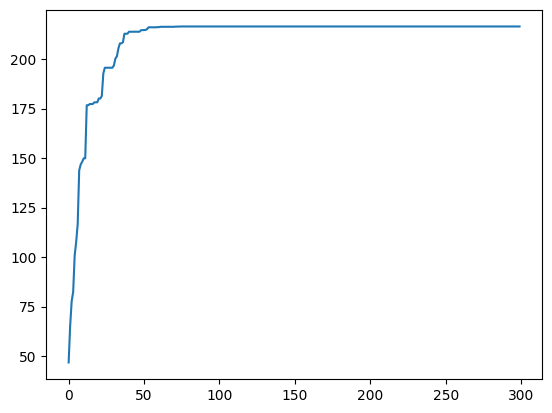

In [28]:
gga.epoch_fitness
# plot the fitness of the best population in each epoch
import matplotlib.pyplot as plt
plt.plot(gga.epoch_fitness)

In [29]:
gga.epoch_num_per_group

[[9, 9, 4, 7, 5, 15, 8, 6, 7, 5, 5, 9, 6, 5],
 [6, 10, 9, 10, 12, 7, 9, 8, 10, 8, 6, 5],
 [9, 9, 5, 8, 6, 5, 6, 9, 10, 5, 4, 5, 5, 8, 6],
 [9, 11, 8, 3, 5, 8, 6, 7, 9, 9, 8, 5, 6, 6],
 [5, 4, 3, 2, 3, 4, 3, 4, 3, 4, 1, 3, 6, 10, 9, 10, 6, 3, 1, 1, 1, 5, 9],
 [7, 7, 7, 4, 5, 5, 6, 5, 10, 9, 4, 9, 3, 10, 5, 4],
 [8, 6, 9, 5, 9, 5, 6, 8, 5, 6, 6, 8, 6, 7, 6],
 [11, 8, 11, 6, 8, 5, 9, 8, 9, 9, 5, 11],
 [6, 7, 9, 9, 6, 6, 8, 5, 8, 8, 8, 4, 7, 3, 6],
 [7, 8, 7, 5, 5, 3, 7, 8, 6, 5, 4, 6, 10, 9, 10],
 [7, 4, 9, 4, 6, 9, 6, 7, 5, 3, 7, 8, 6, 10, 9],
 [9, 5, 6, 7, 7, 4, 9, 4, 9, 6, 3, 7, 8, 6, 10],
 [5, 10, 6, 8, 9, 5, 6, 6, 6, 7, 7, 6, 6, 7, 6],
 [5, 10, 6, 8, 9, 5, 6, 6, 6, 7, 7, 6, 6, 7, 6],
 [6, 8, 7, 6, 7, 5, 6, 6, 5, 10, 8, 6, 7, 6, 7],
 [6, 8, 7, 6, 7, 5, 6, 6, 5, 10, 8, 6, 7, 6, 7],
 [6, 8, 7, 6, 7, 5, 6, 6, 5, 10, 8, 6, 7, 6, 7],
 [2, 6, 6, 4, 5, 6, 2, 5, 6, 6, 6, 6, 5, 7, 2, 3, 4, 1, 6, 6, 2, 1, 2, 1],
 [2, 6, 6, 4, 5, 6, 2, 5, 6, 6, 6, 6, 5, 7, 2, 3, 4, 1, 6, 6, 2, 1, 2, 1],
 [5, 8, 

In [30]:
for v in df.values:
    print(v)

[1.  0.  0.  0.5 0.  0.  0.5 0.  0.  0.  0.  3. ]
[2.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  5. ]
[3.  0.  0.  0.  0.5 0.  0.  0.  0.  0.  0.5 2. ]
[4.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  3. ]
[5.  0.  0.  0.5 0.  0.  0.5 0.  0.  0.  0.  2. ]
[6.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  2. ]
[7.  0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.5 3. ]
[8.  0.  0.5 0.  0.  0.  0.5 0.  0.  0.  0.  5. ]
[9.  0.  0.5 0.  0.  0.  0.5 0.  0.  0.  0.  2. ]
[10.   0.5  0.5  0.   0.   0.   0.   0.   0.   0.   0.   5. ]
[11.   0.   0.   0.   0.   0.5  0.5  0.   0.   0.   0.   3. ]
[12.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.5  2. ]
[13.   0.   0.   0.   0.5  0.   0.   0.   0.   0.5  0.   4. ]
[14.   0.5  0.   0.   0.5  0.   0.   0.   0.   0.   0.   4. ]
[15.   0.5  0.   0.5  0.   0.   0.   0.   0.   0.   0.   4. ]
[16.   0.   0.   0.   0.   0.   0.5  0.   0.   0.5  0.   2. ]
[17.   0.5  0.   0.   0.5  0.   0.   0.   0.   0.   0.   1. ]
[18.   0.   0.   0.   0.   0.5  0.   0.   0.   0.5  0.

In [31]:

        # total_client_num = sum(group.get_clients_num() for group in child1_groups) + sum(group.get_clients_num() for group in p1_groups_confict)
        # total_client = [client for group in p1_groups_confict for client in group.get_clients()] + [client for group in child1_groups for client in group.get_clients()]
        # sorted_clients = sorted(total_client, key=lambda client: client.clientID)
        # sorted_clients_id = [client.clientID for client in sorted_clients]
        # print('stop')

        #  for i in range(p1_groups_num):
        #     if i < p1_points[0] or i > p1_points[1]:
        #         group = parent1.get_group_by_id(i)
        #         confict = False
        #         for client in group.get_clients()[::-1]: #反向切片避免删除错误
        #             if client in p2_missing_clients: # 多余的clients
        #                 group.remove_client(client)
        #                 confict = True
        #         if confict and group.get_clients_num() > 0:
        #                 p1_groups_confict.append(group)
        #         if not confict:
        #             child1_groups.append(group)

                
        # for i in range(p2_groups_num):
        #     if i < p2_points[0] or i > p2_points[1]:
        #         group = parent2.get_group_by_id(i)
        #         confict = False
        #         for client in group.get_clients()[::-1]: #for in remove有误
        #             if client  in p1_missing_clients:
        #                 group.remove_client(client)
        #                 confict = True
        #         if confict and group.get_clients_num() > 0:
        #                 p2_groups_confict.append(group)
        #         if not confict:
        #             child2_groups.append(group)       


        # for i in range(p1_groups_num):
        #     if i < p1_points[0] or i > p1_points[1]:
        #         group = parent1.get_group_by_id(i)
        #         confict = False
        #         for client in group.get_clients()[::-1]: #反向切片避免删除错误
        #             if client in p2_missing_clients: # 多余的clients
        #                 group.remove_client(client)
        #                 confict = True
        #         if confict and group.get_clients_num() > 0:
        #                 p1_groups_confict.append(group)
        #         if not confict:
        #             child1_groups.append(group)

                
        # for i in range(p2_groups_num):
        #     if i < p2_points[0] or i > p2_points[1]:
        #         group = parent2.get_group_by_id(i)
        #         confict = False
        #         for client in group.get_clients()[::-1]: #for in remove有误
        #             if client  in p1_missing_clients:
        #                 group.remove_client(client)
        #                 confict = True
        #         if confict and group.get_clients_num() > 0:
        #                 p2_groups_confict.append(group)
        #         if not confict:
        #             child2_groups.append(group)

        
        # if len(p1_missing_clients) > 0:
        #     p1_groups_confict.append(Group(p1_missing_clients))

        # if len(p2_missing_clients) > 0:
        #     p2_groups_confict.append(Group(p2_missing_clients))

        # del p1_missing_clients, p2_missing_clients